# HDB Resale Price Prediction

## Machine Learning Modelling

### Import Libraries

In [2]:
# General
import math
import random
random.seed(42)
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import randint

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colour_palette = sns.color_palette("hls", 8)
import scikitplot as skplt
from sklearn import tree

# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import OneHotEncoder

# Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# import lightgbm as ltb
import catboost as cb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [3]:
# Importing Data
data_hdb_cleaned = pd.read_csv('../dataset/hdb_last15_cleaned.csv')
data_hdb_cleaned.index += 1
data_hdb_cleaned

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,...,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,region,price_per_sqm
1,SEMBAWANG,5 ROOM,Premium Apartment,111.0,362000.0,2009-07-01,2001,01 TO 05,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3261.261261
2,SEMBAWANG,5 ROOM,Premium Apartment,110.0,370000.0,2009-08-01,2001,06 TO 10,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3363.636364
3,SEMBAWANG,5 ROOM,Premium Apartment,110.0,403000.0,2010-01-01,2001,16 TO 20,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3663.636364
4,SEMBAWANG,4 ROOM,Premium Apartment,95.0,350000.0,2010-07-01,2001,01 TO 05,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3684.210526
5,SEMBAWANG,4 ROOM,Premium Apartment,95.0,399000.0,2010-07-01,2001,10 TO 15,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,4200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316854,BUKIT MERAH,5 ROOM,Improved,114.0,921000.0,2022-10-01,1974,10 TO 15,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8078.947368
316855,BUKIT MERAH,5 ROOM,Improved,117.0,930000.0,2022-10-01,1974,01 TO 05,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,7948.717949
316856,BUKIT MERAH,5 ROOM,Improved,117.0,978000.0,2022-12-01,1974,10 TO 15,87,50.666667,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8358.974359
316857,BUKIT MERAH,5 ROOM,Improved,114.0,950000.0,2022-12-01,1974,21 TO 25,87,50.583333,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8333.333333


In [4]:
# Understanding Data I
data_hdb_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316858 entries, 1 to 316858
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   town                                    316858 non-null  object 
 1   flat_type                               316858 non-null  object 
 2   flat_model                              316858 non-null  object 
 3   floor_area_sqm                          316858 non-null  float64
 4   resale_price                            316858 non-null  float64
 5   month                                   316858 non-null  object 
 6   lease_commence_date                     316858 non-null  int64  
 7   storey_range                            316858 non-null  object 
 8   block                                   316858 non-null  object 
 9   remaining_lease                         316858 non-null  float64
 10  address                                 3168

In [5]:
# Understanding Data II
data_hdb_cleaned.describe()

,floor_area_sqm,resale_price,lease_commence_date,remaining_lease,lat,long,nearest_distance_to_mrt,avg_long,avg_lat,healthcare_within_1km_count,...,recreational_within_1km_count,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,price_per_sqm
count,316858.000000,3.168580e+05,316858.00000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,...,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316410.000000,316858.000000
mean,97.479359,4.412566e+05,1991.72968,75.267866,1.365842,103.838676,0.624044,103.838680,1.365844,5.988376,...,3.837429,3.928042,11.887855,4.055404,4.855336,4.037460,14.403837,4.095730,551205.063677,4581.617630
std,24.742062,1.467689e+05,11.84791,11.684112,0.042881,0.072799,0.378055,0.072687,0.042815,5.242842,...,3.054143,0.688451,8.638953,0.134527,2.244488,0.574591,4.698377,0.183904,186035.992530,1181.663412
min,31.000000,1.270000e+05,1966.00000,43.000000,1.270380,103.644248,0.023000,103.688247,1.272255,0.000000,...,0.000000,0.000000,2.000000,3.577778,0.000000,0.000000,2.000000,2.786667,50004.000000,1445.920000
25%,74.000000,3.360000e+05,1984.00000,66.000000,1.336264,103.774173,0.337000,103.774336,1.336320,3.000000,...,2.000000,3.933333,8.000000,3.983333,3.000000,3.975000,12.000000,3.994737,470709.000000,3798.076923
50%,97.000000,4.150000e+05,1989.00000,75.000000,1.362565,103.844027,0.552000,103.844611,1.362350,5.000000,...,3.000000,4.050000,10.000000,4.075000,5.000000,4.133333,14.000000,4.130000,560323.000000,4368.932039
75%,113.000000,5.150000e+05,2000.00000,85.000000,1.392710,103.898351,0.828000,103.898503,1.391577,8.000000,...,5.000000,4.150000,13.000000,4.136364,6.000000,4.266667,17.000000,4.205263,680518.000000,5074.626866
max,280.000000,1.418000e+06,2018.00000,94.916667,1.457071,103.964915,2.154000,103.962400,1.455540,61.000000,...,41.000000,4.700000,105.000000,4.380000,19.000000,5.000000,37.000000,4.500000,825195.000000,14731.182796


### Split Training & Testing Dataset

In [6]:
# Dependent Variable
target_list = ['resale_price']

# Independent Variables
feature_list = ['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease',
                'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 
                'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 
                'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 
                'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count',
                'education_within_2km_average_rating', 'region', 'price_per_sqm']

print(feature_list)

# Selecting Target Variable and Features from Dataset
X = data_hdb_cleaned[feature_list]
y = data_hdb_cleaned[target_list]

['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease', 'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count', 'education_within_2km_average_rating', 'region', 'price_per_sqm']


In [7]:
# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253486, 21) (63372, 21) (253486, 1) (63372, 1)


In [8]:
# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Data Preprocessing

#### Data Cleaning

In [9]:
# Check Missing Data
X_train.isnull().sum()[X_train.isnull().sum() > 0]
X_test.isnull().sum()[X_test.isnull().sum() > 0]

Series([], dtype: int64)

In [11]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   flat_type                               253486 non-null  object 
 1   floor_area_sqm                          253486 non-null  float64
 2   month                                   253486 non-null  object 
 3   lease_commence_date                     253486 non-null  int64  
 4   storey_range                            253486 non-null  object 
 5   remaining_lease                         253486 non-null  float64
 6   nearest_distance_to_mrt                 253486 non-null  float64
 7   healthcare_within_1km_count             253486 non-null  float64
 8   healthcare_within_1km_average_rating    253486 non-null  float64
 9   healthcare_within_2km_count             253486 non-null  float64
 10  healthcare_within_2km_average_rating    2534

Upon visual inspection of the dataset, the month column more accurate represents the date sold. The datetime data type would be more appropriate.

In [12]:
# Rename month column to better reflect data
X_train = X_train.rename(columns={'month': 'date_sold'})
X_test = X_test.rename(columns={'month': 'date_sold'})

# Change data type
X_train['date_sold'] = pd.to_datetime(X_train['date_sold'])
X_train['flat_type'] = X_train['flat_type'].astype('category')
X_train['region'] = X_train['region'].astype('category')

X_test['date_sold'] = pd.to_datetime(X_test['date_sold'])
X_test['flat_type'] = X_test['flat_type'].astype('category')
X_test['region'] = X_test['region'].astype('category')

#### Data Transformation

In [ ]:
# DT Methods i.e. StandardScaler, PowerTransformer



### Feature Engineering

#### Encoding

In [13]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_train_one_hot_flat_type = pd.get_dummies(X_train['flat_type'], prefix='flat_type')
X_train_one_hot_storey_range = pd.get_dummies(X_train['storey_range'], prefix='storey_range')
X_train_one_hot_region = pd.get_dummies(X_train['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_flat_type, X_train_one_hot_storey_range, X_train_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   floor_area_sqm                          253486 non-null  float64       
 1   date_sold                               253486 non-null  datetime64[ns]
 2   lease_commence_date                     253486 non-null  int64         
 3   remaining_lease                         253486 non-null  float64       
 4   nearest_distance_to_mrt                 253486 non-null  float64       
 5   healthcare_within_1km_count             253486 non-null  float64       
 6   healthcare_within_1km_average_rating    253486 non-null  float64       
 7   healthcare_within_2km_count             253486 non-null  float64       
 8   healthcare_within_2km_average_rating    253486 non-null  float64       
 9   recreational_within_1km_count        

In [14]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_test_one_hot_flat_type = pd.get_dummies(X_test['flat_type'], prefix='flat_type')
X_test_one_hot_storey_range = pd.get_dummies(X_test['storey_range'], prefix='storey_range')
X_test_one_hot_region = pd.get_dummies(X_test['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_flat_type, X_test_one_hot_storey_range, X_test_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63372 entries, 0 to 63371
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   floor_area_sqm                          63372 non-null  float64       
 1   date_sold                               63372 non-null  datetime64[ns]
 2   lease_commence_date                     63372 non-null  int64         
 3   remaining_lease                         63372 non-null  float64       
 4   nearest_distance_to_mrt                 63372 non-null  float64       
 5   healthcare_within_1km_count             63372 non-null  float64       
 6   healthcare_within_1km_average_rating    63372 non-null  float64       
 7   healthcare_within_2km_count             63372 non-null  float64       
 8   healthcare_within_2km_average_rating    63372 non-null  float64       
 9   recreational_within_1km_count           63372 non-

### Feature Extraction 

In [15]:
# Principal Component Analysis

# Initialise PCA with 10 components
pca = PCA(n_components=10)


# Exclude datetime as PCA only accepts numeric
X_train_numeric = X_train_encoded.drop(columns=['date_sold'])
pca.fit(X_train_numeric)

X_train_pca = pca.transform(X_train_numeric)

print("Shape of Transformed Data", X_train_pca.shape)

Shape of Transformed Data (253486, 10)


### Feature Selection

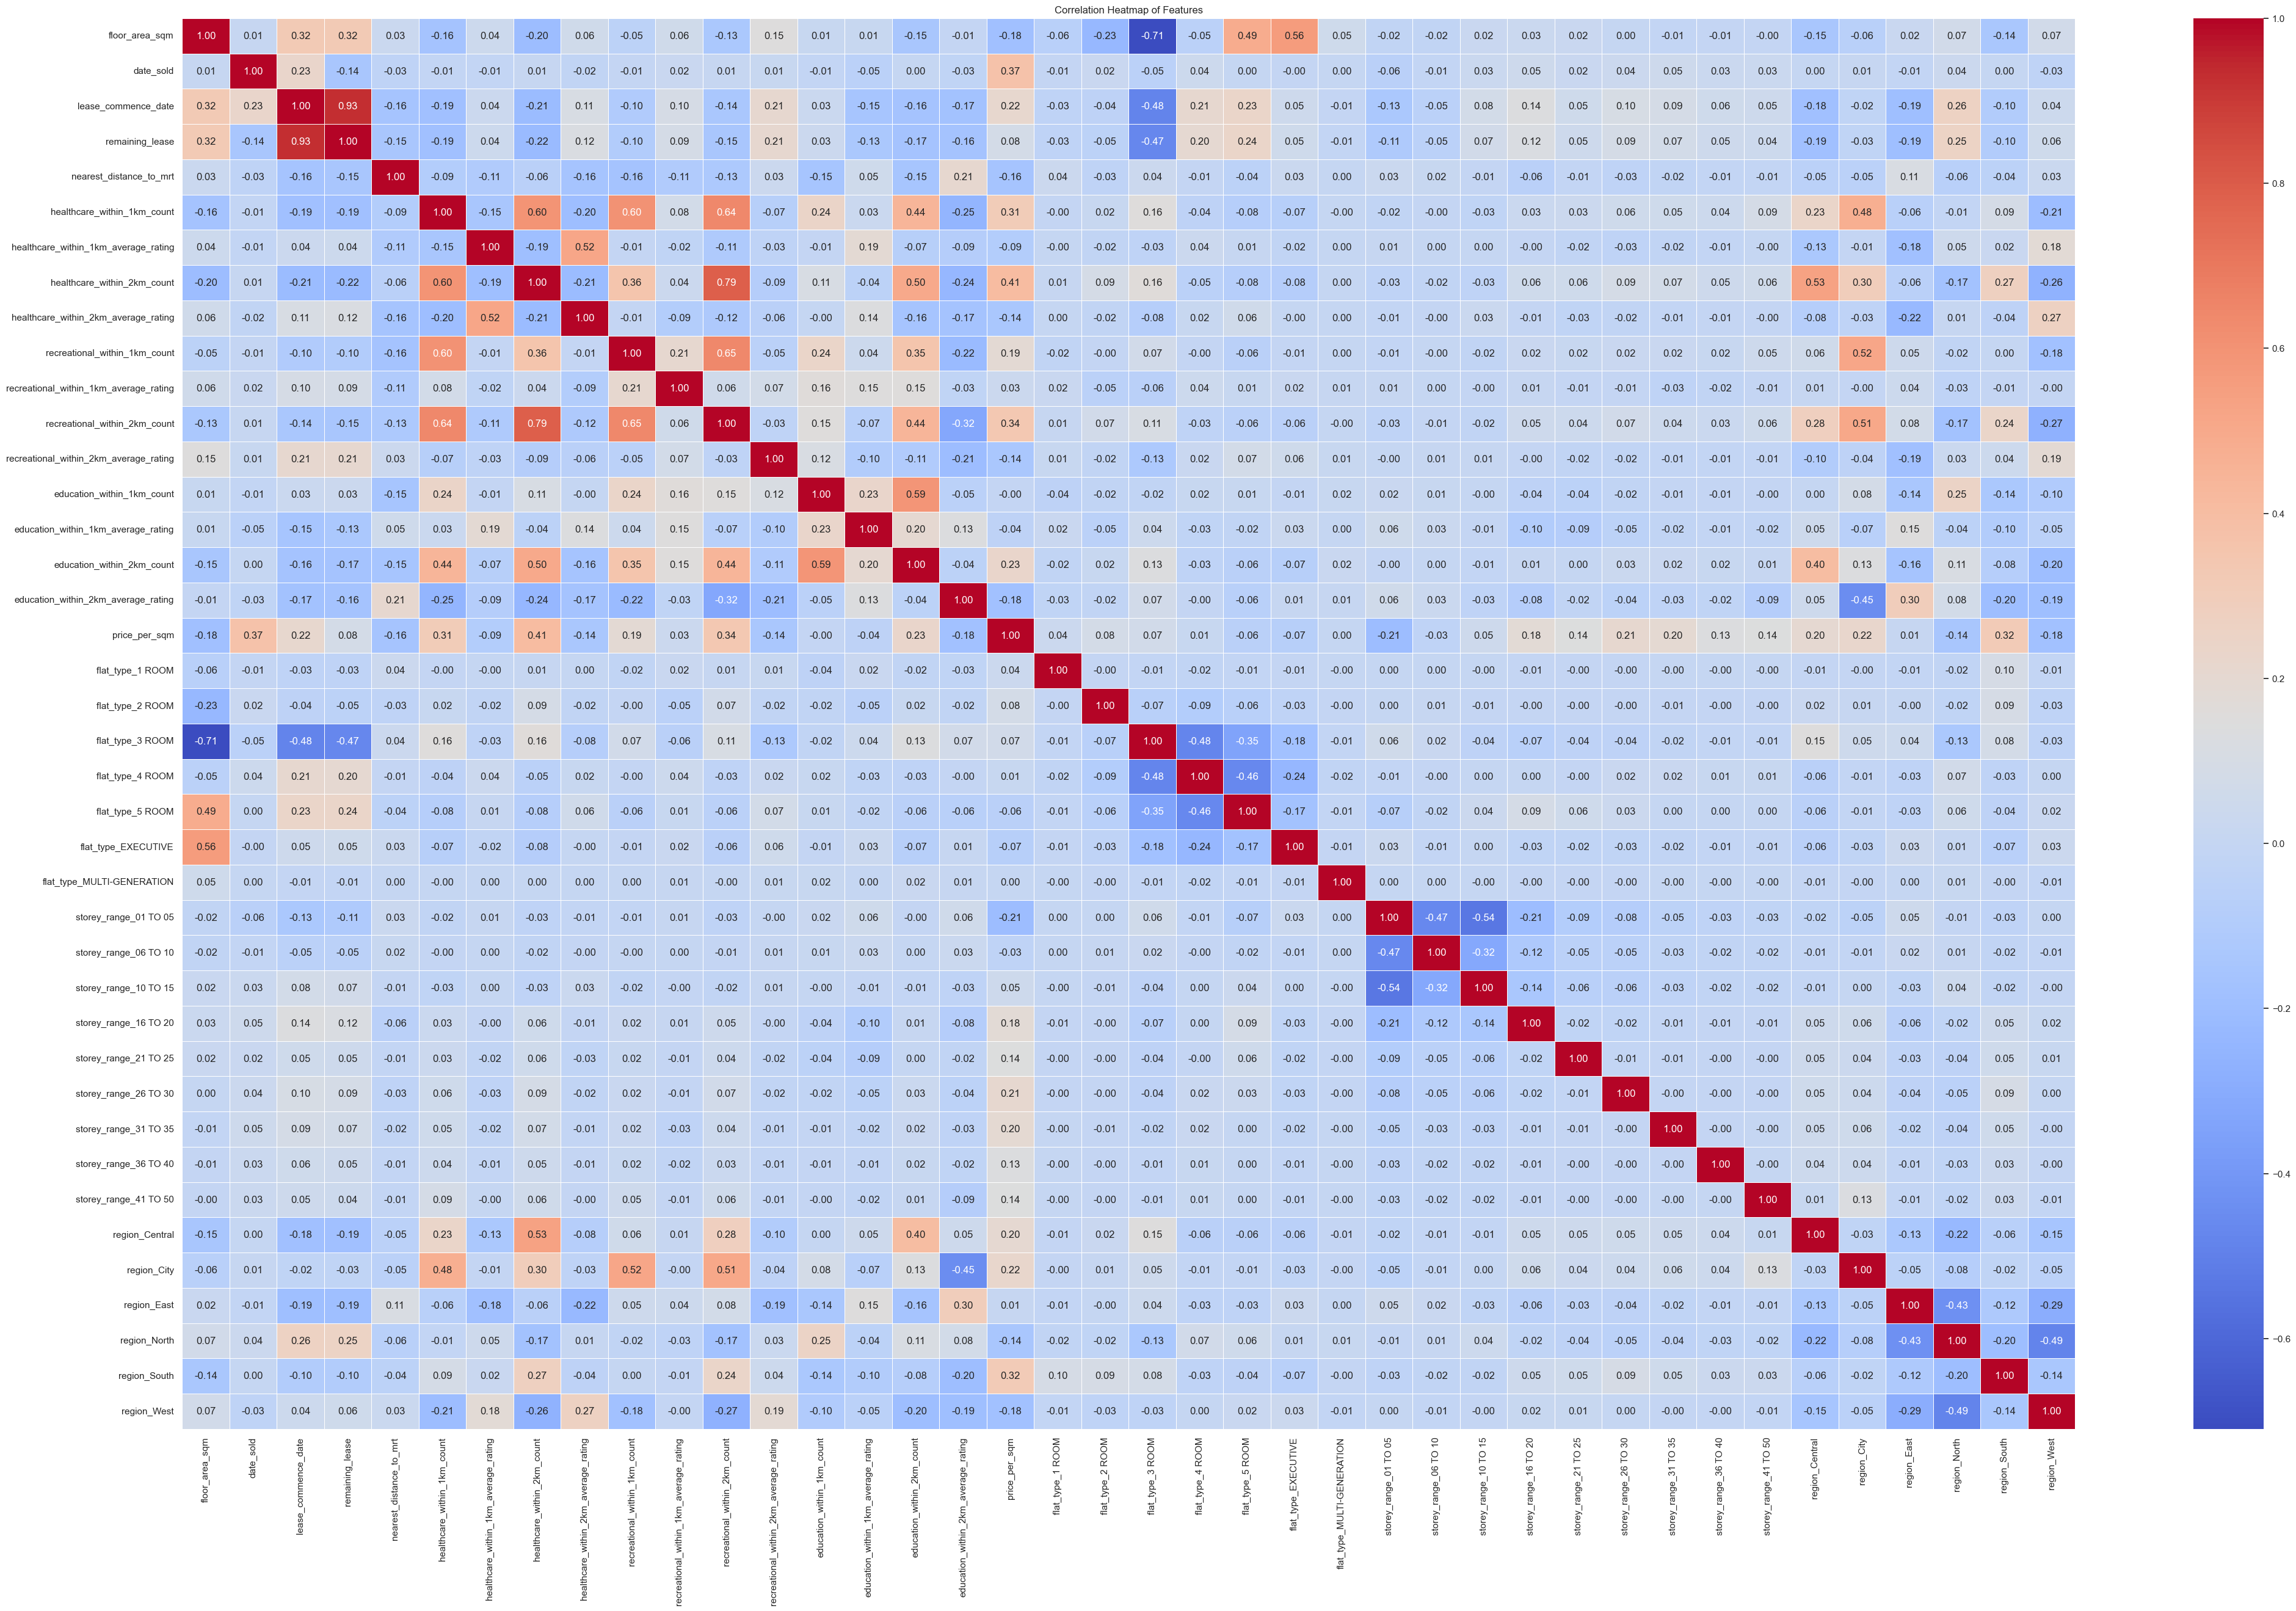

In [16]:
# Compute the correlation matrix
corr_matrix = X_train_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(50, 30))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap of Features')

# Show the plot
plt.show()

In [16]:
# Initialize VarianceThreshold with the desired threshold
threshold = 0.05  
selector = VarianceThreshold(threshold)

# Fit the selector to your data
selector.fit(X_train_numeric)

# Get the indices of all features
all_indices = range(len(X_train_numeric.columns))

# Get the indices of the features that are retained
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train_numeric.columns[selected_indices]

# Display the selected features
print("Selected features:", selected_features)

# Get the indices of the features that are not selected
not_selected_indices = list(set(all_indices) - set(selected_indices))

# Get the names of the features that are not selected
not_selected_features = X_train_numeric.columns[not_selected_indices]

# Display the features that are not selected
print("Not selected features:", not_selected_features)

Selected features: Index(['floor_area_sqm', 'lease_commence_date', 'remaining_lease',
       'nearest_distance_to_mrt', 'healthcare_within_1km_count',
       'healthcare_within_1km_average_rating', 'healthcare_within_2km_count',
       'healthcare_within_2km_average_rating', 'recreational_within_1km_count',
       'recreational_within_1km_average_rating',
       'recreational_within_2km_count', 'education_within_1km_count',
       'education_within_1km_average_rating', 'education_within_2km_count',
       'price_per_sqm', 'flat_type_3 ROOM', 'flat_type_4 ROOM',
       'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'storey_range_01 TO 05',
       'storey_range_06 TO 10', 'storey_range_10 TO 15'],
      dtype='object')
Not selected features: Index(['storey_range_41 TO 50', 'recreational_within_2km_average_rating',
       'education_within_2km_average_rating', 'flat_type_1 ROOM',
       'flat_type_2 ROOM', 'flat_type_MULTI-GENERATION',
       'storey_range_16 TO 20', 'storey_range_21 TO 25',


In [17]:
# Keep selected features

# Drop Highly Correlated lease_commence_date (with remaining_lease) and date_sold
X_train_selected = X_train_encoded.drop(columns=['lease_commence_date', 'date_sold'])
X_test_selected = X_test_encoded.drop(columns=['lease_commence_date', 'date_sold'])

# # Transform your data to keep only the selected features
# X_train_selected = selector.transform(X_train_numeric)

# # Convert the transformed data back to a DataFrame (if needed)
# X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)

print(X_train_selected.info())
print(X_test_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   floor_area_sqm                          253486 non-null  float64
 1   remaining_lease                         253486 non-null  float64
 2   nearest_distance_to_mrt                 253486 non-null  float64
 3   healthcare_within_1km_count             253486 non-null  float64
 4   healthcare_within_1km_average_rating    253486 non-null  float64
 5   healthcare_within_2km_count             253486 non-null  float64
 6   healthcare_within_2km_average_rating    253486 non-null  float64
 7   recreational_within_1km_count           253486 non-null  float64
 8   recreational_within_1km_average_rating  253486 non-null  float64
 9   recreational_within_2km_count           253486 non-null  float64
 10  recreational_within_2km_average_rating  2534

## Machine Learning Modelling

### Regression Metrics

1. **Mean Absolute Error (MAE)**
   - Formula: $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $
   - Description: The average of the absolute differences between the predicted values and actual values. It gives an idea of how wrong the predictions were.


2. **Mean Squared Error (MSE)**
   - Formula: $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
   - Description: The average of the squared differences between the predicted values and actual values. It penalizes larger errors more than MAE.


3. **Root Mean Squared Error (RMSE)**
   - Formula: $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $
   - Description: The square root of the average of the squared differences between the predicted values and actual values. It is in the same units as the response variable and is sensitive to outliers.


4. **R-squared (Coefficient of Determination)**
   - Formula: $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $
   - Description: The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides a measure of how well observed outcomes are replicated by the model.


5. **Adjusted R-squared**
   - Formula: $ \text{Adjusted } R^2 = 1 - (1-R^2)\frac{n-1}{n-p-1} $
   - Description: Adjusted for the number of predictors in the model. It accounts for the phenomenon where the R-squared value increases with the addition of predictors, regardless of their relevance.

In [18]:
# Evaluation 
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r_squared = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared Coefficient (R^2):", r_squared)
    

### Baseline Modelling 

We will trial a selected few baseline models to evaluate their performance before selecting the best baseline model to proceed with Hyperparameter Tuning and the subsequent Advanced Modelling which builds on top of Baseline Modelling.

##### Model Training

In [21]:
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 15968.631902656252
Root Mean Squared Error (RMSE): 24681.576272378465
R-squared Coefficient (R^2): 0.9718874176216241


In [22]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 380.8339494374487
Root Mean Squared Error (RMSE): 2551.629899927857
R-squared Coefficient (R^2): 0.9996995374686211


##### Cross Validation

<AxesSubplot:title={'center':'Decision Tree Regressor Learning Curve'}, xlabel='Training examples', ylabel='Score'>

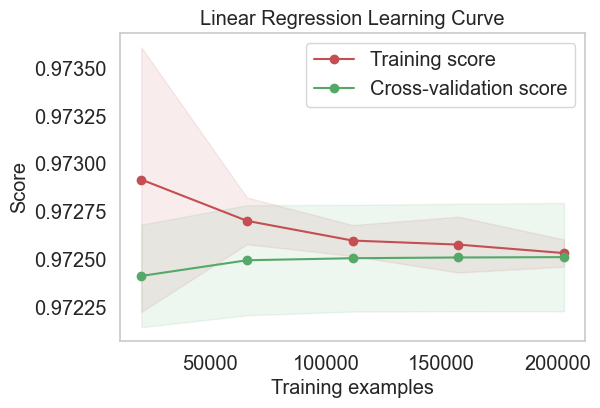

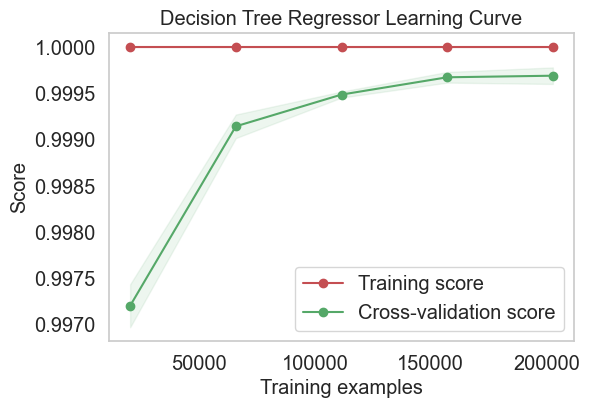

In [23]:
# Learning curves
skplt.estimators.plot_learning_curve(LinearRegression(), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Linear Regression Learning Curve")

skplt.estimators.plot_learning_curve(DecisionTreeRegressor(), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Regressor Learning Curve")

Training Score Curve shows the models' performance based on goodness of fit on the training dataset as a function of the number of training examples used. This indicates the Decision Tree Regressor fits the training data better than Linear Regression. Validation Score Curve shows the models' performance based on goodness of fit on a separate validation dataset as a function of the number of training examples used. This indicates the Decision Tree Regressor generalises better than Linear Regresion to unseen data.

Given Decision Tree Regressor outperforms Linear Regression as it has a greater R-Squared Coefficient of 0.99970 > 0.97161, we will be proceeding with Decision Tree Regressor as our baseline model.

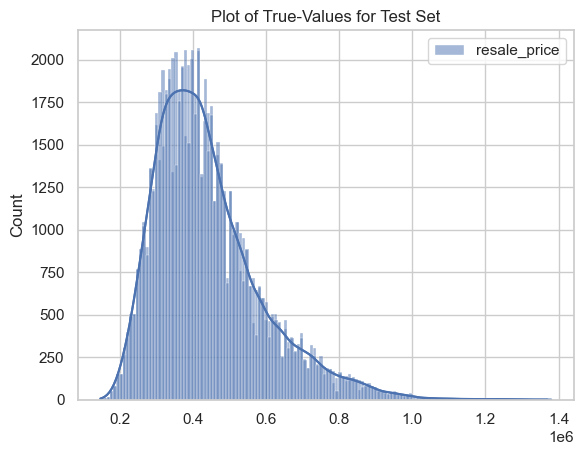

In [24]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_dtr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

In [25]:
# Print Text Representation of Decision Tree Regressor rules
text_representation_dtr = tree.export_text(reg_dtr)
print(text_representation_dtr)

|--- feature_0 <= 84.50
|   |--- feature_15 <= 5889.65
|   |   |--- feature_15 <= 4340.92
|   |   |   |--- feature_0 <= 74.50
|   |   |   |   |--- feature_15 <= 3752.77
|   |   |   |   |   |--- feature_15 <= 3418.55
|   |   |   |   |   |   |--- feature_0 <= 65.50
|   |   |   |   |   |   |   |--- feature_15 <= 3137.03
|   |   |   |   |   |   |   |   |--- feature_0 <= 62.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 53.00
|   |   |   |   |   |   |   |   |   |   |--- feature_14 <= 4.01
|   |   |   |   |   |   |   |   |   |   |   |--- value: [140000.00]
|   |   |   |   |   |   |   |   |   |   |--- feature_14 >  4.01
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- feature_0 >  53.00
|   |   |   |   |   |   |   |   |   |   |--- feature_15 <= 2525.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_15 >  2525.00
|   |   |   |   |   |

In [ ]:
# # Features used
# feature_names = X_train_selected.columns

# # Visualising Decision Tree
# fig_dtr = plt.figure(figsize = (25, 20))
# _ = tree.plot_tree(reg_dtr, 
#                    feature_names = feature_names,  
#                    filled = True)

##### Hyperparameter Tuning

In [26]:
# Decision Tree Model Parameters
reg_dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [27]:
# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
    
# Use RandomSearch to narrow the scope of parameters for GridSearch
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": ["auto", "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

Best Parameters For Decision Tree: {'max_depth': 15, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8}


In [28]:
# Use GridSearch from RandomizedSearch best parameters
params = { 
    'max_depth': [12, 13, 14, 15, 16, 17, 18],     
    'min_samples_split': [5, 6, 7, 8, 9, 10], 
    'min_samples_leaf': [2, 3, 4, 5, 6],
    "max_features": [None],
}

gscv_dtr = GridSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_grid = params, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = gscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_gscv_dtr = gscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 16, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 8}
Mean Absolute Error (MAE): 563.711228385409
Root Mean Squared Error (RMSE): 2776.1681950103584
R-squared Coefficient (R^2): 0.9996443305972846


##### Feature Evaluation

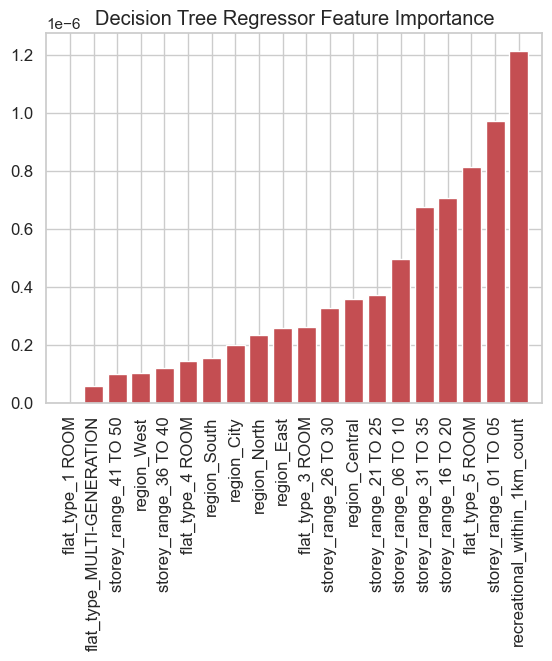

In [29]:
# Features used
feature_names = X_train_selected.columns

# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_dtr, feature_names = feature_names,
                                         title="Decision Tree Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Decision Tree Regressor Feature Importance plot displays the significance of each attribute in the regression model. The features, labeled on the x-axis, are ranked according to their importance scores on the y-axis. A higher bar denotes a greater influence on the model's predictions, with "recreational_within_1km_average_rating" standing out as the most impactful feature in this particular model.

### Advanced Modelling 

From the Baseline Decision Tree Model, we will look into more complex Ensemble models for better performance.

#### Random Forest Regressor

In [30]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 258.08432826793694
Root Mean Squared Error (RMSE): 2023.5988591796502
R-squared Coefficient (R^2): 0.9998110252373648


In [ ]:
## USE CELLS HERE

#### XGBoost Regressor

In [31]:
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

Mean Absolute Error (MAE): 2134.119503526794
Root Mean Squared Error (RMSE): 3257.7717873405286
R-squared Coefficient (R^2): 0.9995102253842172


In [ ]:
## USE CELLS HERE

#### LightGBM Regressor

In [ ]:
reg_lgbmr = LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgmbr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

In [ ]:
## USE CELLS HERE

#### CatBoost Regressor

In [32]:
reg_cbr = cb.CatBoostRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_cbr = reg_cbr.predict(X_test_selected)

evaluate(y_test, y_pred_cbr)

Learning rate set to 0.098176
0:	learn: 134020.5054193	total: 220ms	remaining: 3m 39s
1:	learn: 122693.7651249	total: 269ms	remaining: 2m 14s
2:	learn: 112477.1006504	total: 309ms	remaining: 1m 42s
3:	learn: 103318.3793759	total: 337ms	remaining: 1m 24s
4:	learn: 94937.7826116	total: 370ms	remaining: 1m 13s
5:	learn: 87568.3701672	total: 397ms	remaining: 1m 5s
6:	learn: 80778.1631082	total: 424ms	remaining: 1m
7:	learn: 74604.1849115	total: 453ms	remaining: 56.2s
8:	learn: 68898.8551763	total: 487ms	remaining: 53.7s
9:	learn: 63786.6137374	total: 517ms	remaining: 51.2s
10:	learn: 59157.9998965	total: 544ms	remaining: 48.9s
11:	learn: 54941.0897478	total: 572ms	remaining: 47.1s
12:	learn: 50903.1354794	total: 598ms	remaining: 45.4s
13:	learn: 47465.9487283	total: 627ms	remaining: 44.1s
14:	learn: 44223.0234515	total: 653ms	remaining: 42.9s
15:	learn: 41215.4546549	total: 682ms	remaining: 42s
16:	learn: 38537.7827454	total: 713ms	remaining: 41.2s
17:	learn: 36035.3148244	total: 741ms	rem

155:	learn: 4970.1026418	total: 5.9s	remaining: 31.9s
156:	learn: 4962.7695796	total: 5.95s	remaining: 31.9s
157:	learn: 4946.6769068	total: 6s	remaining: 32s
158:	learn: 4935.0028375	total: 6.04s	remaining: 31.9s
159:	learn: 4922.8997120	total: 6.07s	remaining: 31.9s
160:	learn: 4908.9562097	total: 6.12s	remaining: 31.9s
161:	learn: 4891.9769124	total: 6.17s	remaining: 31.9s
162:	learn: 4885.4948561	total: 6.2s	remaining: 31.9s
163:	learn: 4876.9720874	total: 6.25s	remaining: 31.8s
164:	learn: 4860.8899826	total: 6.29s	remaining: 31.8s
165:	learn: 4851.8147693	total: 6.33s	remaining: 31.8s
166:	learn: 4840.2794772	total: 6.38s	remaining: 31.8s
167:	learn: 4826.3087083	total: 6.42s	remaining: 31.8s
168:	learn: 4814.1729437	total: 6.46s	remaining: 31.7s
169:	learn: 4807.0595299	total: 6.49s	remaining: 31.7s
170:	learn: 4787.6169911	total: 6.55s	remaining: 31.8s
171:	learn: 4775.0218154	total: 6.6s	remaining: 31.8s
172:	learn: 4763.9268747	total: 6.64s	remaining: 31.8s
173:	learn: 4753.1

309:	learn: 3827.2738579	total: 12.6s	remaining: 28s
310:	learn: 3824.9714177	total: 12.6s	remaining: 27.9s
311:	learn: 3819.2154084	total: 12.6s	remaining: 27.9s
312:	learn: 3813.7363277	total: 12.7s	remaining: 27.8s
313:	learn: 3810.4825091	total: 12.7s	remaining: 27.8s
314:	learn: 3803.0177011	total: 12.8s	remaining: 27.8s
315:	learn: 3796.9960495	total: 12.8s	remaining: 27.7s
316:	learn: 3788.3399344	total: 12.9s	remaining: 27.7s
317:	learn: 3783.3681229	total: 12.9s	remaining: 27.7s
318:	learn: 3778.1038769	total: 12.9s	remaining: 27.6s
319:	learn: 3775.0731082	total: 13s	remaining: 27.6s
320:	learn: 3770.0770275	total: 13s	remaining: 27.5s
321:	learn: 3766.1483709	total: 13s	remaining: 27.5s
322:	learn: 3761.1951628	total: 13.1s	remaining: 27.4s
323:	learn: 3757.1639362	total: 13.1s	remaining: 27.4s
324:	learn: 3754.0396035	total: 13.2s	remaining: 27.3s
325:	learn: 3750.5943323	total: 13.2s	remaining: 27.3s
326:	learn: 3746.5877908	total: 13.2s	remaining: 27.2s
327:	learn: 3740.9

463:	learn: 3335.1894466	total: 18.5s	remaining: 21.4s
464:	learn: 3332.6610762	total: 18.5s	remaining: 21.3s
465:	learn: 3329.6329775	total: 18.6s	remaining: 21.3s
466:	learn: 3325.8904717	total: 18.6s	remaining: 21.2s
467:	learn: 3323.6577812	total: 18.6s	remaining: 21.2s
468:	learn: 3321.0534792	total: 18.7s	remaining: 21.1s
469:	learn: 3318.3156743	total: 18.7s	remaining: 21.1s
470:	learn: 3316.4714490	total: 18.8s	remaining: 21.1s
471:	learn: 3312.9568628	total: 18.8s	remaining: 21s
472:	learn: 3310.7790884	total: 18.8s	remaining: 21s
473:	learn: 3309.0363754	total: 18.9s	remaining: 20.9s
474:	learn: 3307.3284799	total: 18.9s	remaining: 20.9s
475:	learn: 3306.1148489	total: 18.9s	remaining: 20.8s
476:	learn: 3304.3186449	total: 19s	remaining: 20.8s
477:	learn: 3303.2371751	total: 19s	remaining: 20.8s
478:	learn: 3302.7112582	total: 19s	remaining: 20.7s
479:	learn: 3299.7585213	total: 19.1s	remaining: 20.7s
480:	learn: 3297.4471785	total: 19.1s	remaining: 20.6s
481:	learn: 3294.060

616:	learn: 3053.9998771	total: 24.6s	remaining: 15.3s
617:	learn: 3052.0177203	total: 24.7s	remaining: 15.3s
618:	learn: 3050.4535281	total: 24.7s	remaining: 15.2s
619:	learn: 3049.7908244	total: 24.8s	remaining: 15.2s
620:	learn: 3047.6729844	total: 24.8s	remaining: 15.1s
621:	learn: 3046.4581451	total: 24.8s	remaining: 15.1s
622:	learn: 3045.3341741	total: 24.9s	remaining: 15.1s
623:	learn: 3043.6647570	total: 24.9s	remaining: 15s
624:	learn: 3041.9634350	total: 25s	remaining: 15s
625:	learn: 3039.6847412	total: 25s	remaining: 14.9s
626:	learn: 3039.0090769	total: 25.1s	remaining: 14.9s
627:	learn: 3037.4969832	total: 25.1s	remaining: 14.9s
628:	learn: 3034.2195858	total: 25.1s	remaining: 14.8s
629:	learn: 3032.6702851	total: 25.2s	remaining: 14.8s
630:	learn: 3031.3807125	total: 25.2s	remaining: 14.7s
631:	learn: 3029.0383027	total: 25.3s	remaining: 14.7s
632:	learn: 3026.5361463	total: 25.3s	remaining: 14.7s
633:	learn: 3024.3289286	total: 25.3s	remaining: 14.6s
634:	learn: 3023.6

767:	learn: 2865.6831630	total: 30.3s	remaining: 9.14s
768:	learn: 2864.3073455	total: 30.3s	remaining: 9.1s
769:	learn: 2862.9059028	total: 30.3s	remaining: 9.06s
770:	learn: 2861.0223019	total: 30.4s	remaining: 9.03s
771:	learn: 2859.7930347	total: 30.4s	remaining: 8.99s
772:	learn: 2858.5524058	total: 30.5s	remaining: 8.95s
773:	learn: 2857.5779387	total: 30.5s	remaining: 8.92s
774:	learn: 2855.1526989	total: 30.6s	remaining: 8.88s
775:	learn: 2853.8970886	total: 30.6s	remaining: 8.84s
776:	learn: 2852.4867993	total: 30.7s	remaining: 8.8s
777:	learn: 2850.9945431	total: 30.7s	remaining: 8.77s
778:	learn: 2849.3882379	total: 30.8s	remaining: 8.73s
779:	learn: 2847.8402719	total: 30.8s	remaining: 8.69s
780:	learn: 2846.8270852	total: 30.8s	remaining: 8.64s
781:	learn: 2846.0325487	total: 30.9s	remaining: 8.6s
782:	learn: 2844.7802625	total: 30.9s	remaining: 8.56s
783:	learn: 2843.9628045	total: 30.9s	remaining: 8.52s
784:	learn: 2842.9311751	total: 31s	remaining: 8.48s
785:	learn: 284

917:	learn: 2706.6895677	total: 36s	remaining: 3.21s
918:	learn: 2705.4466237	total: 36s	remaining: 3.18s
919:	learn: 2704.5969803	total: 36.1s	remaining: 3.14s
920:	learn: 2703.8475129	total: 36.1s	remaining: 3.1s
921:	learn: 2703.1181858	total: 36.1s	remaining: 3.06s
922:	learn: 2702.7466150	total: 36.2s	remaining: 3.02s
923:	learn: 2702.0526676	total: 36.2s	remaining: 2.98s
924:	learn: 2701.2145471	total: 36.3s	remaining: 2.94s
925:	learn: 2700.3827989	total: 36.3s	remaining: 2.9s
926:	learn: 2699.4918938	total: 36.3s	remaining: 2.86s
927:	learn: 2697.7877106	total: 36.4s	remaining: 2.82s
928:	learn: 2696.9150979	total: 36.4s	remaining: 2.78s
929:	learn: 2695.8118575	total: 36.4s	remaining: 2.74s
930:	learn: 2694.5864754	total: 36.5s	remaining: 2.7s
931:	learn: 2693.7823381	total: 36.5s	remaining: 2.66s
932:	learn: 2693.1627139	total: 36.6s	remaining: 2.62s
933:	learn: 2692.6986407	total: 36.6s	remaining: 2.58s
934:	learn: 2691.8801626	total: 36.6s	remaining: 2.55s
935:	learn: 2690.

In [ ]:
## USE CELLS HERE